In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [103]:
#Define Neural Network Model
def nn_model(input_shape = (3,), layers = None):
    input_ = tf.keras.layers.Input(shape = input_shape)
    x = tf.keras.layers.Dense(layers[0], activation = 'tanh')(input_)
    for layer in layers[1:-1]:
        x = tf.keras.layers.Dense(layer, activation = 'tanh')(x)
    output = tf.keras.layers.Dense(layers[-1])(x)
    model = tf.keras.Model(input_, output)
    return model
    
#Define PDE Layers
def compute_pde(model, x, y, t, alpha = 1e-4):
    with tf.GradientTape(persistent = True) as tape:
        tape.watch([x,y,t])
        u = model(tf.stack([x,y,t], axis = 1))
        u_x = tape.gradient(u,x)
        u_y = tape.gradient(u,y)
        u_t = tape.gradient(u,t)
    u_xx = tape.gradient(u_x, x)
    u_yy = tape.gradient(u_y, y)
    del tape
    
    f = u_t - alpha*(u_xx+u_yy)
    return f

#Compute Loss Function of U
def compute_loss(model, x, y, t, u_init):
    # PDE Loss
    f = compute_pde(model, x, y, t)
    mse_f = tf.reduce_mean(tf.square(f))
    
    #Initial Loss -- u(x,t=0)
    t_init = tf.zeros_like(x)
    u_init_p = model(tf.stack([x, y, t_init], axis = 1))
    mse_init = tf.reduce_mean(tf.square(u_init_p-u_init))
    
    mse_total = mse_init + mse_f
    return mse_total
    
    #Boundary Loss (Drichlet and Neumann)
    #----

# Training Step
@tf.function
def train_step(model, optimizer, x, y, t, u_init):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x, y, t, u_init)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


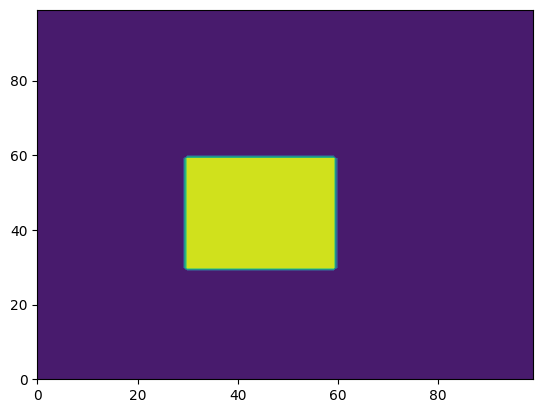

In [113]:
#Initializing X,Y,T
x = np.linspace(0,1,100, dtype = np.float32)
y = np.linspace(0,1,100, dtype = np.float32)
t = np.linspace(0,1,100, dtype = np.float32).reshape(-1,1)

X,Y = np.meshgrid(x,y)
u_init = np.zeros_like(X)
u_init[30:60, 30:60] = 1.
plt.contourf(u_init)


In [105]:
X = tf.constant(X.reshape(-1,1), dtype=tf.float32)
Y = tf.constant(Y.reshape(-1,1), dtype = tf.float32)
t = tf.constant(np.tile(t, (100,1)), dtype=tf.float32)
u_init = tf.constant(u_init.reshape(-1,1), dtype = tf.float32)

In [106]:
# Build and compile the model
model = nn_model(input_shape=(3,), layers = [64,64,128,128,1])

optimizer = tf.keras.optimizers.Adam()

# Training loop
epochs = 1000
for epoch in range(epochs):
    loss = train_step(model, optimizer, X, Y, t, u_init)
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.numpy()}')

Epoch 0, Loss: 0.2147590070962906
Epoch 100, Loss: 0.07888887077569962
Epoch 200, Loss: 0.05930120125412941
Epoch 300, Loss: 0.045152582228183746
Epoch 400, Loss: 0.02962052822113037
Epoch 500, Loss: 0.020340021699666977
Epoch 600, Loss: 0.01845530793070793
Epoch 700, Loss: 0.017381684854626656
Epoch 800, Loss: 0.016391178593039513
Epoch 900, Loss: 0.014120045118033886


In [107]:
# Predict and Visualization
x_new = np.linspace(0,1,100).reshape(-1,1)
y_new = np.linspace(0,1,100).reshape(-1,1)
t_new = np.linspace(0,10,100).reshape(-1,1)

X_new, Y_new, T_new = np.meshgrid(x_new, y_new, t_new, indexing = 'ij')
shape = X_new.shape

X_new_tf = tf.constant(X_new.reshape(-1,1), dtype=tf.float32)
Y_new_tf = tf.constant(Y_new.reshape(-1,1), dtype = tf.float32)
T_new_tf = tf.constant(T_new.reshape(-1,1), dtype=tf.float32)

input_new = tf.concat([X_new_tf, Y_new_tf, T_new_tf], axis=1)
u_pred = model.predict(input_new)
u_pred = u_pred.reshape(shape)

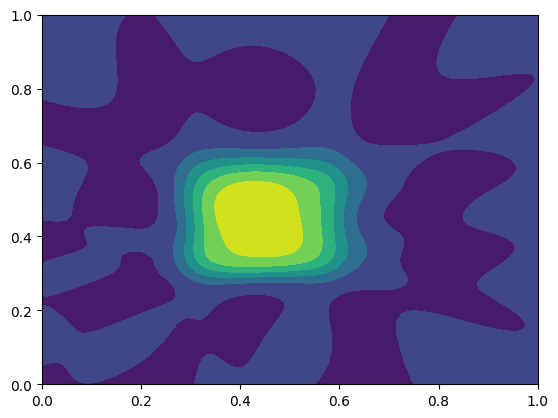

In [111]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
contour = ax.contourf(X_new[:,:,0], Y_new[:,:,0], u_pred[:,:,0])

def update(frame):
    ax.clear()  # Clear previous plot # Reset y-axis limits
    contour = ax.contourf(X_new[:,:,0], Y_new[:,:,0], u_pred[:,:,frame])
    return contour

num_frames = u_pred.shape[-1]
ani = FuncAnimation(fig, update, frames=num_frames, interval=200)

plt.show()

In [112]:
ani.save('animation_contour.gif', writer='Pillow', fps=10)

MovieWriter Pillow unavailable; using Pillow instead.
